In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

#### DATA ####
# https://downloads.psl.noaa.gov/Datasets/
from functions import *
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

2024-07-15 14:32:18.741860


# SST anomalies timeseries


# [Monthly timeseries](#monthly)

# Zonal wind anomalies timeseries

# [Monthly timeseries](#monthly_u)

# WAMOI

## [West African Monsoon Onset](#test)

# ACT
## [Atlantic Cold Tongue Onset](#test3)

# AMM
## [Atlantic Meridional mode index](#test2)

# AMO
## [Atlantic Multi-decadal Oscillation](#test4)

# St Helena SLP index 
## [SLP index](#test5)

# [Identification of Atlantic Niños/Niños and Benguela Niños/Niñas](#test9)

# PIRATA data 

# [Temperature PIRATA 23˚W, 10˚W, 0˚E ](./plot_daily_PIRATA.html)

# [Canonical/Non-canonical Atlantic Niños](#test6)

# [Indian Ocean Dipole](#test7)

# [Seasonal forecast CFSv2](#test8)

# References
# [link](#test20)

# Regions of interests

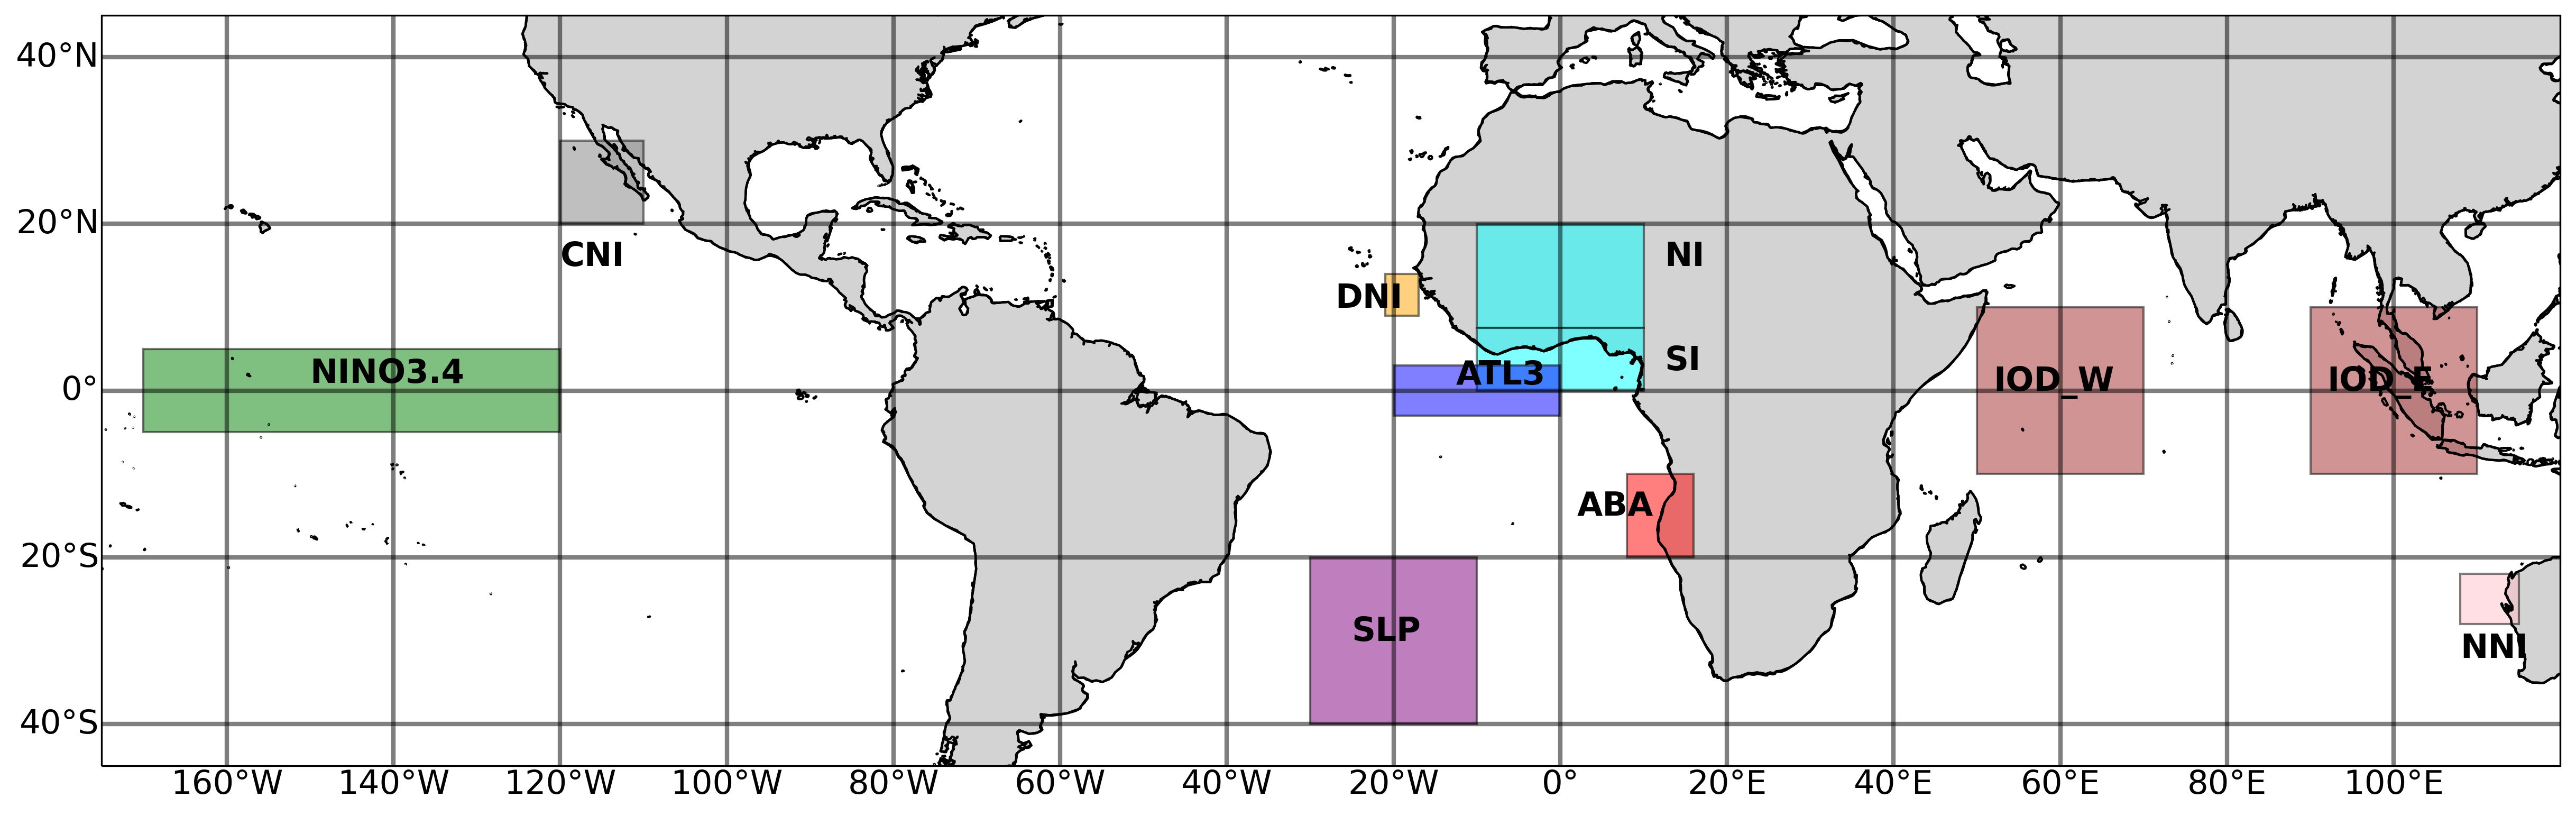

In [2]:
Image(filename='fig_boxes_map.png') 

# Last update 

In [3]:
print(str(now)[:16])

2024-07-15 14:32


# Read SST data 

In [4]:
path_data = 'http://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc'
(ssta_atl3_norm_cobe,ssta_aba_norm_cobe,
 ssta_nino34_norm_cobe,ssta_dni_norm_cobe,
 ssta_cni_norm_cobe,ssta_nni_norm_cobe,iod_cobe) = read_data_compute_anomalies(path_data)

In [5]:
#path_oi = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
#path_oi = 'http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
#(ssta_atl3_norm_oi,ssta_aba_norm_oi,
# ssta_nino34_norm_oi,ssta_dni_norm_oi,
# ssta_cni_norm_oi,ssta_nni_norm_oi,iod_index) = read_data_compute_anomalies_oi(path_oi)

In [6]:
path_ersstv5 = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
(ssta_atl3_norm_ersst,ssta_aba_norm_ersst,
 ssta_nino34_norm_ersst,ssta_dni_norm_ersst,
 ssta_cni_norm_ersst,ssta_nni_norm_ersst,iod_ersst) = read_data_compute_anomalies_ersstv5(path_ersstv5)

# Timeseries of SST anomalies

# Monthly data <a id='monthly'></a>


# [COBE SST](https://psl.noaa.gov/data/gridded/data.cobe.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

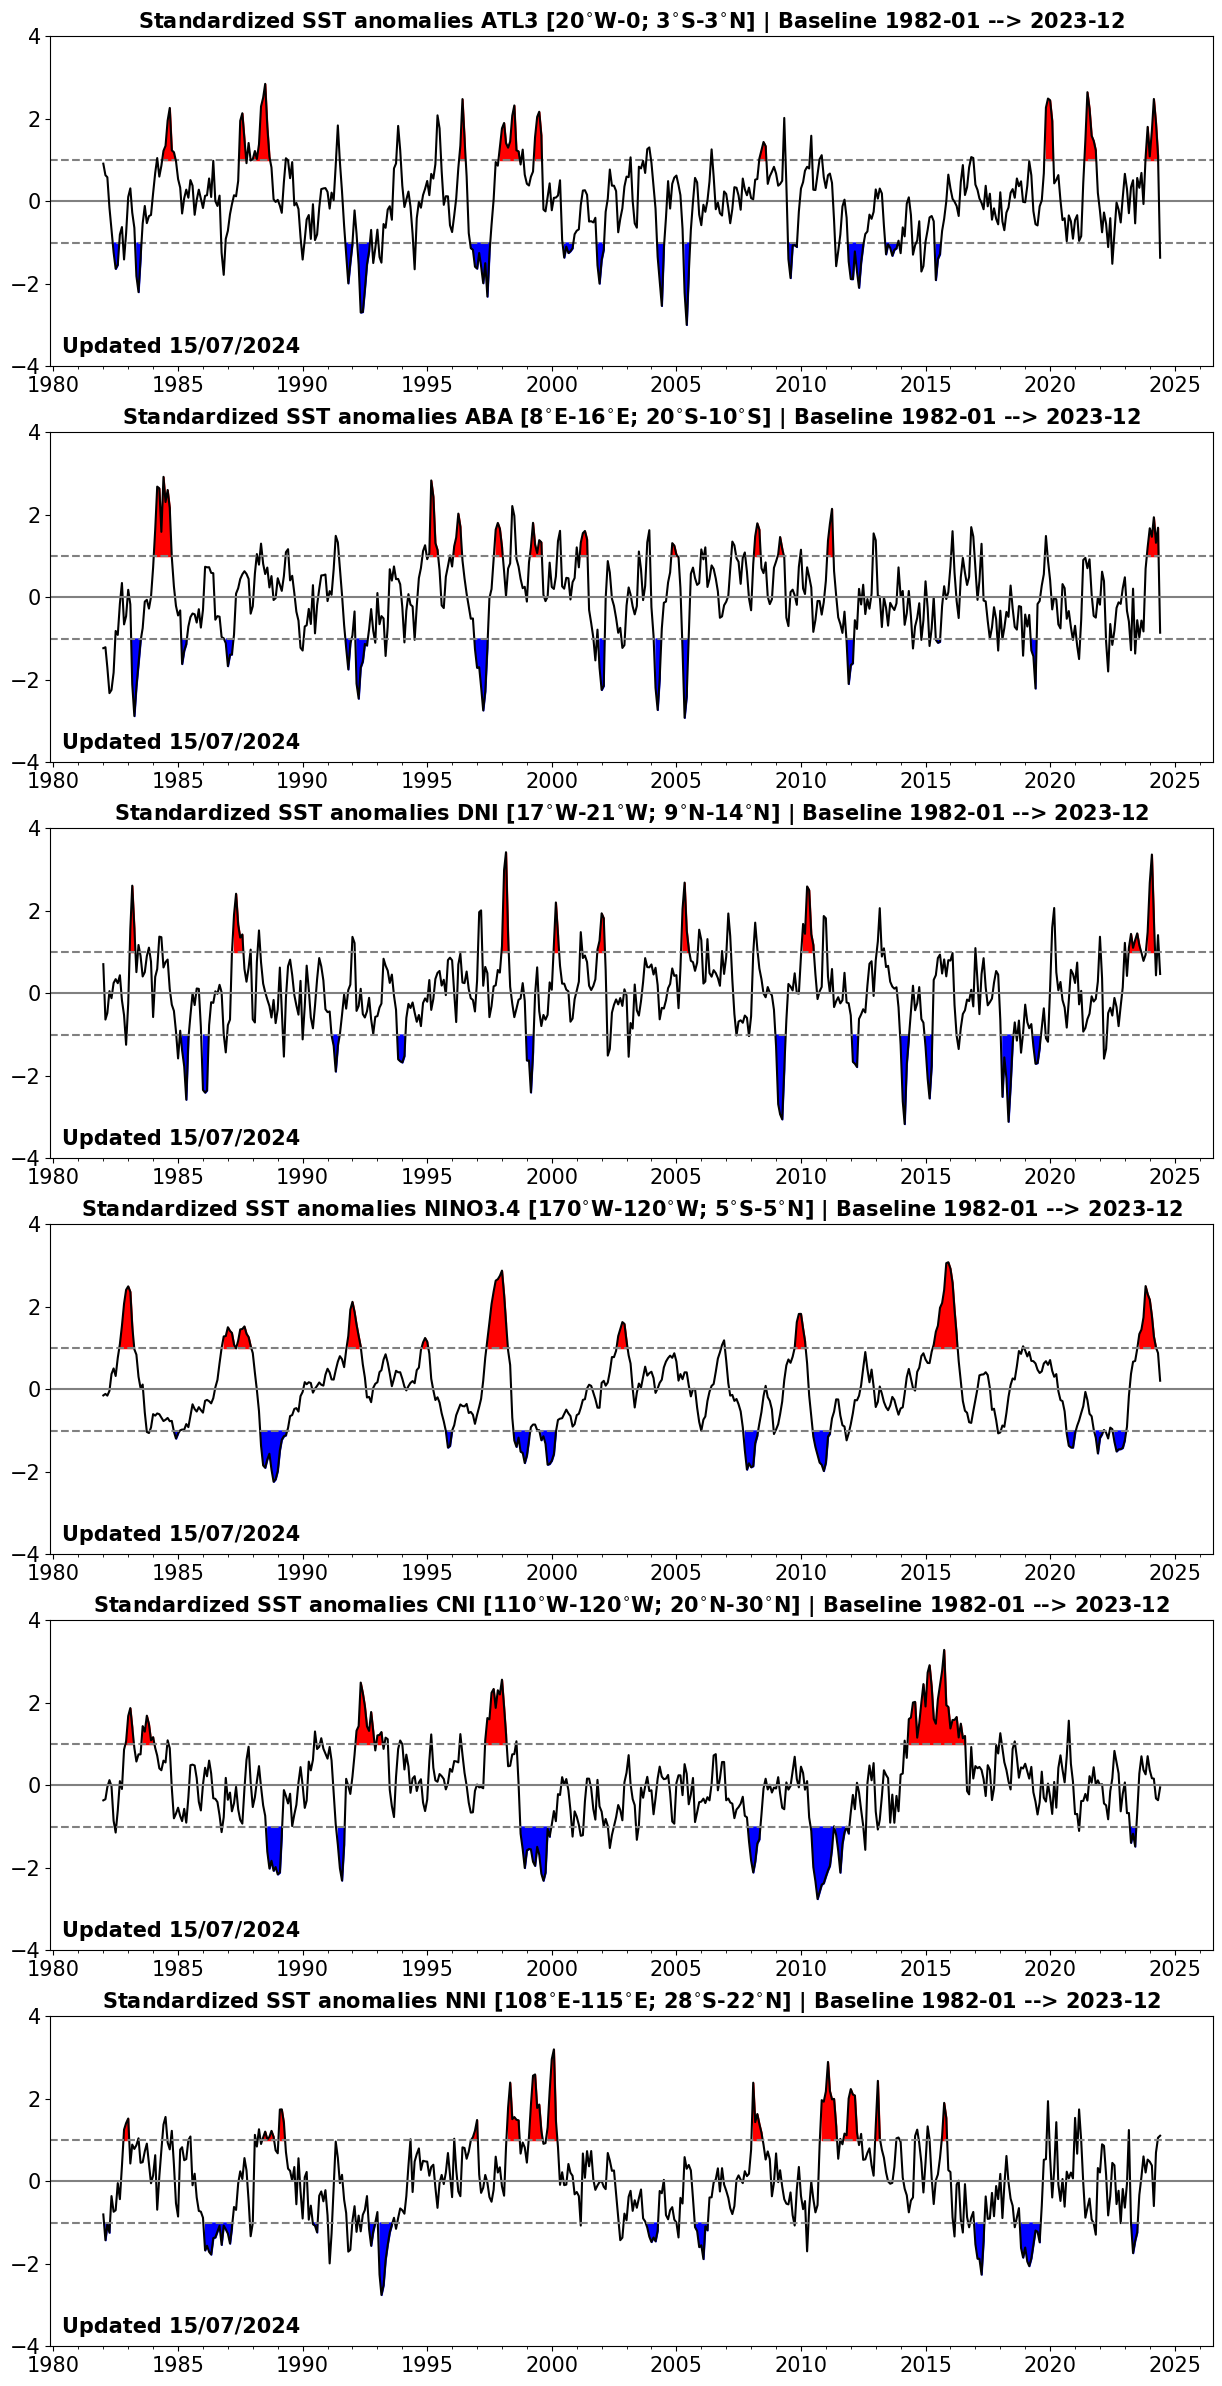

In [7]:
plot_anomalies(ssta_atl3_norm_cobe,
               ssta_aba_norm_cobe,
               ssta_nino34_norm_cobe,
               ssta_dni_norm_cobe,
               ssta_cni_norm_cobe,
               ssta_nni_norm_cobe)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

In [8]:
#plot_anomalies(ssta_atl3_norm_oi,
#               ssta_aba_norm_oi,
#               ssta_nino34_norm_oi,
#               ssta_dni_norm_oi,
#               ssta_cni_norm_oi,
#               ssta_nni_norm_oi)

# [ERSST V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) | 2$^{\circ}$ x 2$^{\circ}$ | Monthly

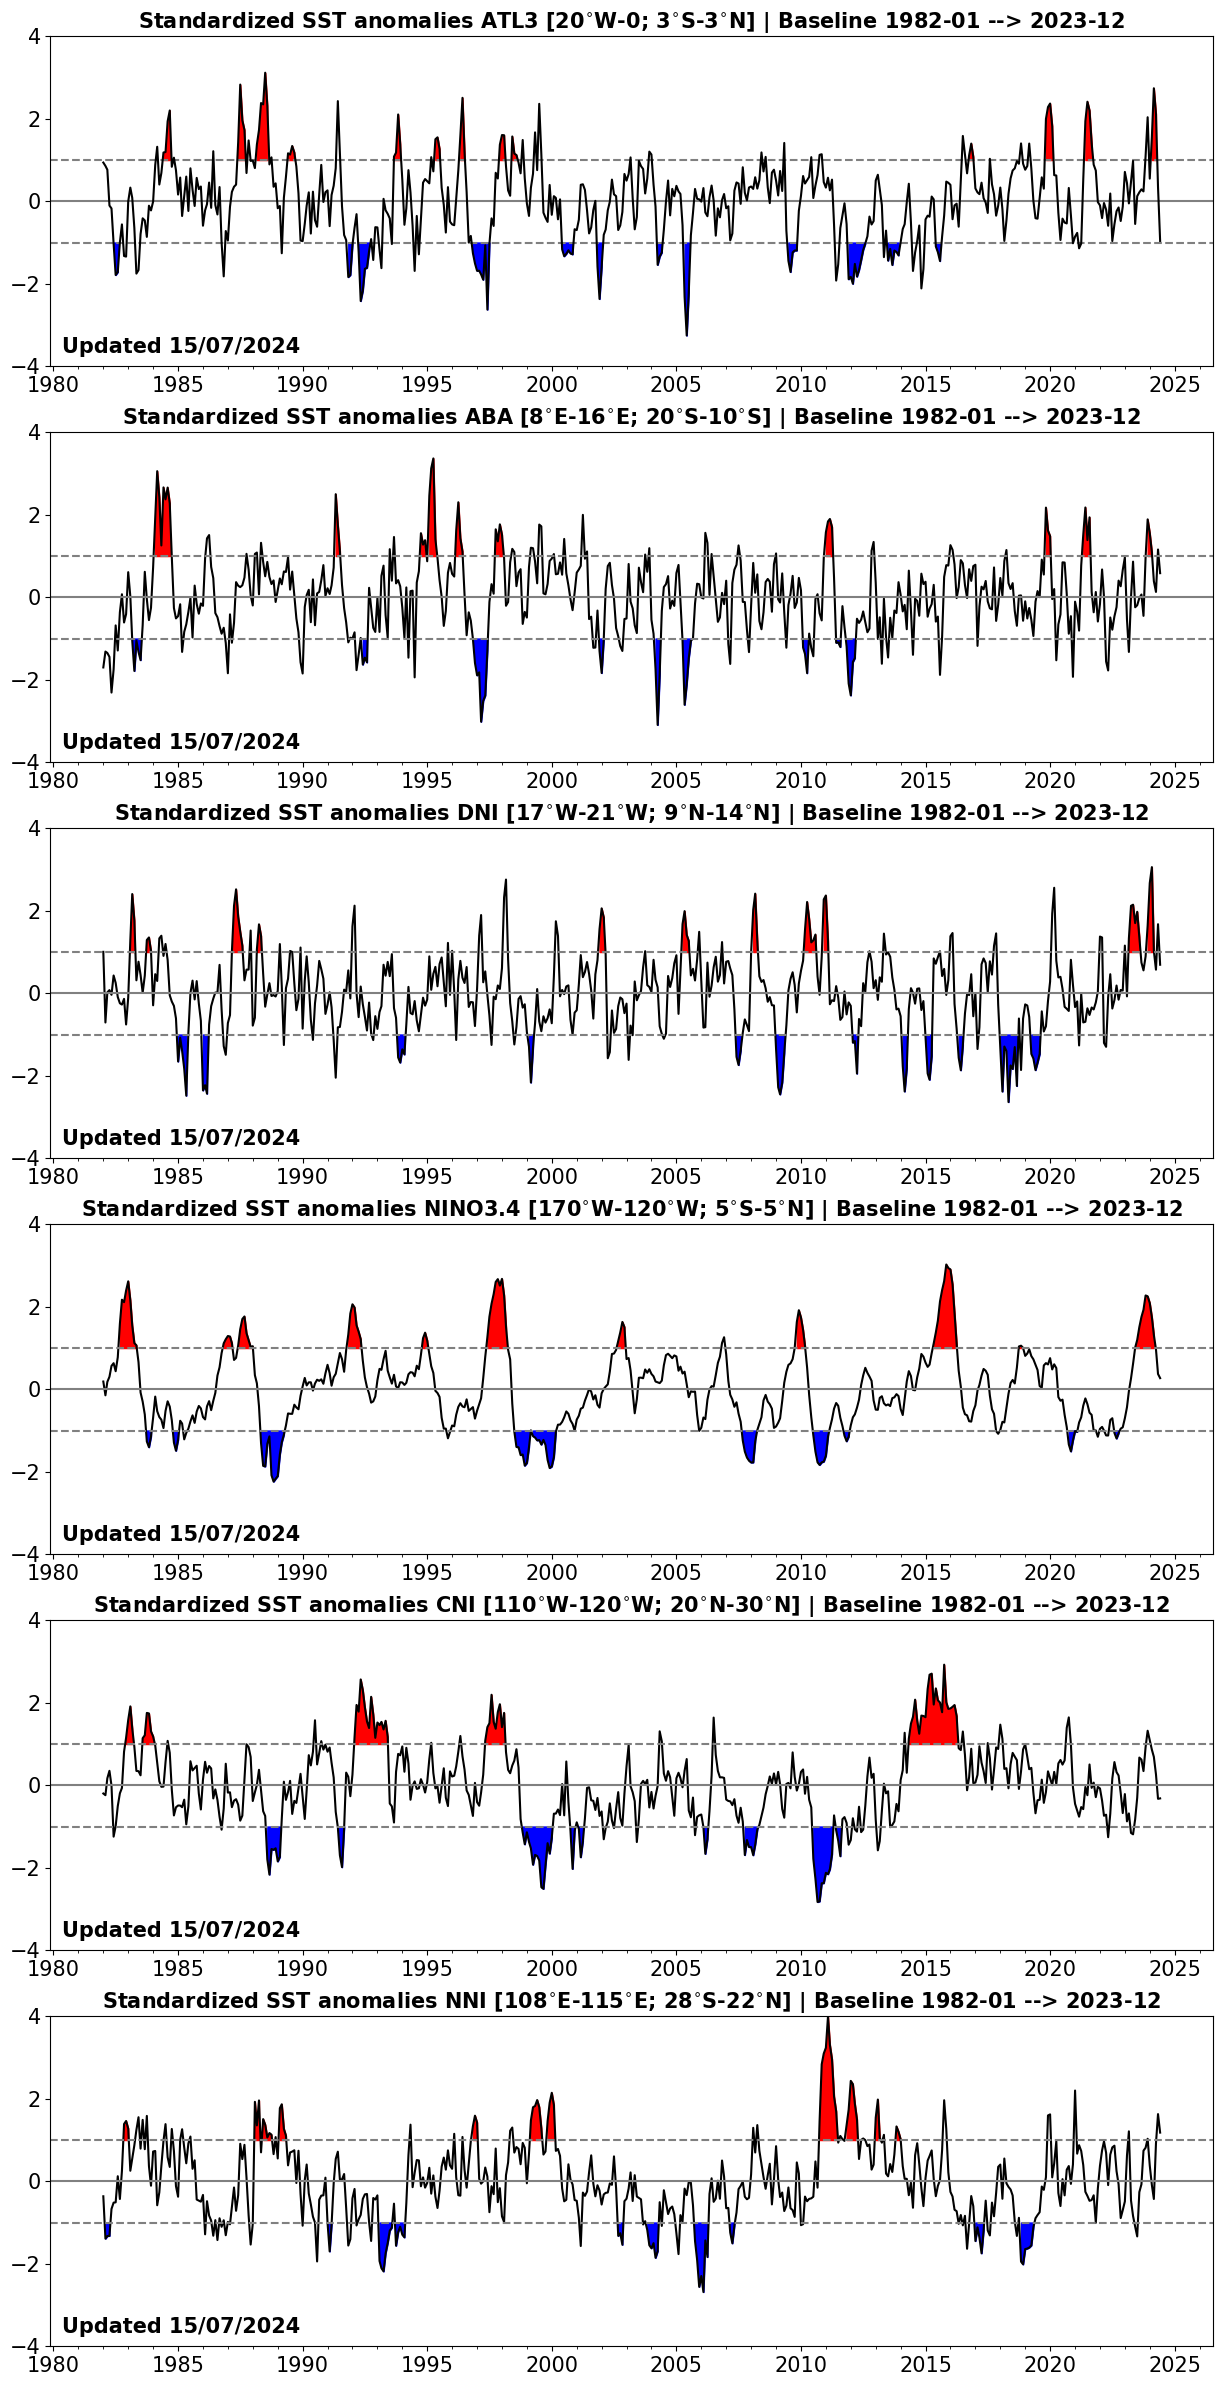

In [9]:
plot_anomalies(ssta_atl3_norm_ersst,
               ssta_aba_norm_ersst,
               ssta_nino34_norm_ersst,
               ssta_dni_norm_ersst,
               ssta_cni_norm_ersst,
               ssta_nni_norm_ersst)

# ATL4 zonal wind <a id='monthly_u'></a>

# [NCEP-V1](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html) | 2 x 2 | Monthly 

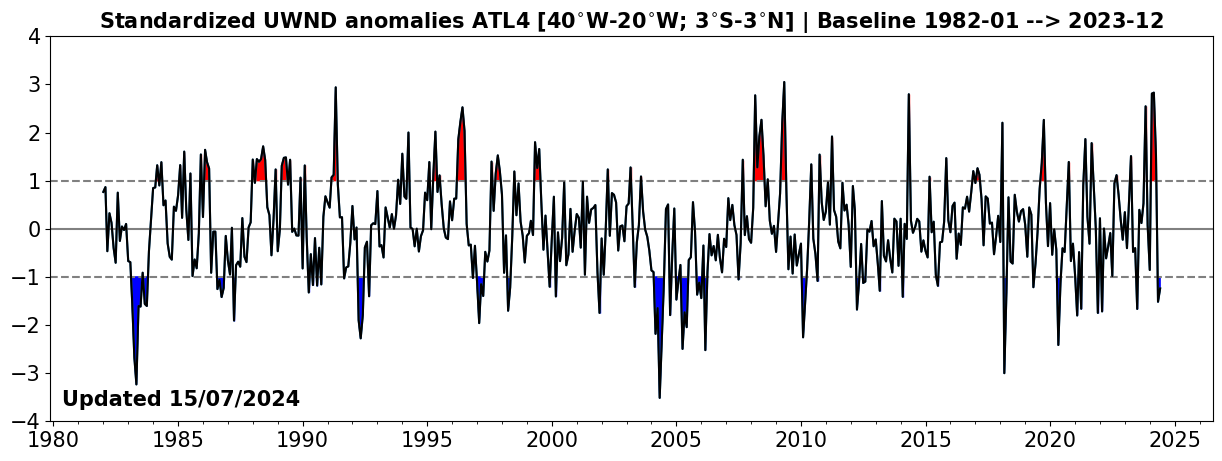

In [10]:
ncep_data = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/uwnd.mon.mean.nc'
uwnda_atl4_norm = read_compute_anomalies_uwind_plot(ncep_data)

# WAMOI: West African Monsoon onset index from 2000 to present day 
<a id='test'></a>

Methodology from : Fontaine and Louvet (2006)


 # WAMOI = NI$_{std}$ - SI$_{std}$ 
 - with NI being the precipitation averaged over 7.5$^\circ$N-20$^\circ$N; 10$^\circ$W-10$^\circ$E
 - and with SI the precipitation averaged over 0$^\circ$N-7.5$^\circ$N; 10$^\circ$W-10$^\circ$E
 
 --> NI and SI are then standardized i.e. NI$_{std}$ = NI/(std(NI))
 
 
 !! to do apply a butterwoth time filter <15 days !!
 
 
### On the following plot, yearly WAMOI is plotted (grey lines), the mean of the WAMOI over the period 2000-2021 (black line) as well as the current year WAMOI(red line).

# [CPC Merged Analysis of Precipitation](https://psl.noaa.gov/data/gridded/data.cmap.html) | 2.5$^{\circ}$ x 2.5$^{\circ}$ | Weekly 

In [ ]:
path_cmap = 'http://psl.noaa.gov/thredds/dodsC/Datasets/cmap/rt/precip.pentad.mean.rt.nc'
plot_wamoi(path_cmap)

# Atlantic Cold Tongue Onset | Caniaux et al., (2011) | Weekly <a id='test3'></a>

Sact  = $\int_{A(x)} He(25^{\circ}C-SST(x))dA$

where He is the Heaviside function (He = 1 when SST < 25$^{\circ}$C
and 0 otherwise). The SST index expresses the intensity of the
cooling in the ACT and is defined point by point by subtracting
the SST for each grid point from a SST of 25$^{\circ}$C
(so that SSTs below 25$^{\circ}$C imply a positive index) inside
the domain A, 30$^{\circ}$W–12$^{\circ}$E and 5$^{\circ}$S–5$^{\circ}$N.

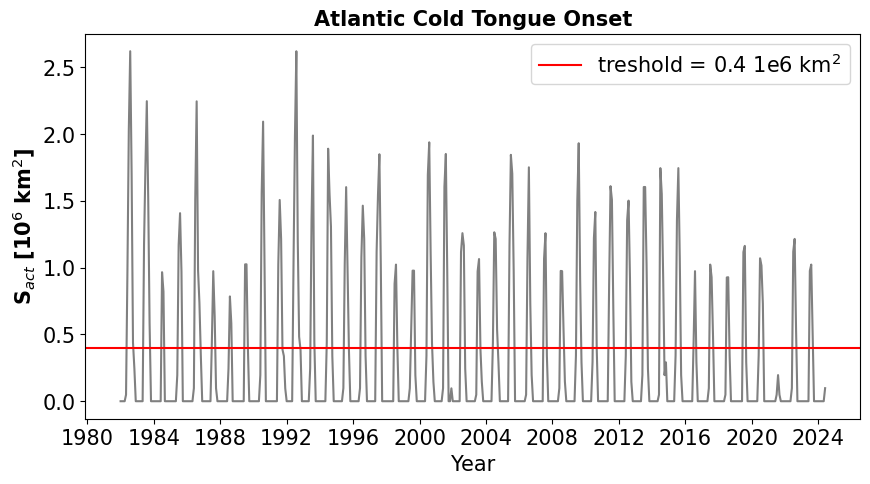

In [12]:
path_ersstv5 = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/'
sst = read_data_ACT_week_plot_ersstv5(path_ersstv5)

# [Atlantic Meridional mode](https://www.aos.wisc.edu/~dvimont/MModes/AMM.html) | Chiang and Vimont (2004) | Monthly  <a id='test2'></a>

The realtime AMM index is defined following the method of Chiang and Vimont (2004). The AMM spatial structure is defined via applying Maximum Covariance Analysis (MCA; Bretherton et al. 1992) is to tropical Atlantic SST and 10m winds over ocean regions between 75E and 15W, 21S to 32N. Data are obtained from the NCEP-NCAR Reanalysis (Kalnay et al. 1996), from NOAA ESRL. The spatial resolution is reduced by averaging three points in the zonal direction, and two points in the latitudinal direction, resulting in approximately 3.8deg latitude by 5.6deg longitude resolution over the region. Next, the seasonal cycle is removed, data are detrended, a three month running mean is applied to the data, and the equatorial Pacific Cold Tongue Index (SST averaged over 180-90W, 6S-6N) is removed (via linear regression) from all points. Finally, the data are weighted by the square root of the cosine of latitude, and the covariance matrix is formed between SST and winds (note the wind fields are appended to each other so the wind state vector has twice as many points as the SST state vector). The covariance matrix is decomposed via Singular Value Decomposition, and the leading statistical mode form the AMM SST and Wind patterns. The time period over which the patterns are computed is frozen as the 1950-2005 time period so that the patterns do not change as the index is being updated.

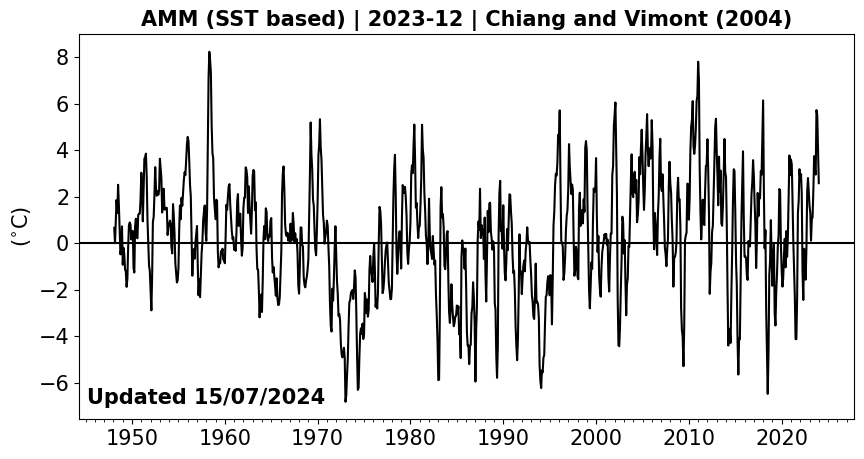

In [13]:
data_amm = 'https://psl.noaa.gov/data/timeseries/monthly/AMM/ammsst.data'
amm_plot_new(data_amm)

# [Atlantic Multi-decadal Oscillation](https://psl.noaa.gov/data/timeseries/AMO/) | Monthly <a id='test4'></a>

In [14]:
#data_amo= 'https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.amo.dat'
#plot_amo_new(data_amo)


# [St Helena index](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html) (SLP based 3-month running mean) | Monthly <a id='test5'></a>

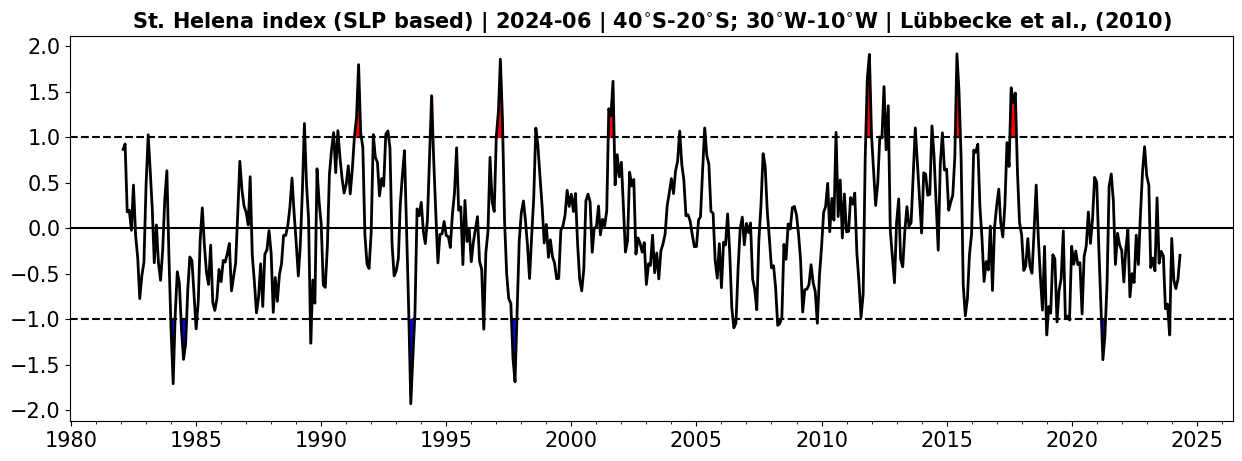

In [15]:
ncep_data_slp = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc'
plot_slp(ncep_data_slp)

# Indian Ocean Dipole index  <a id='test7'></a>

### COBE-SST

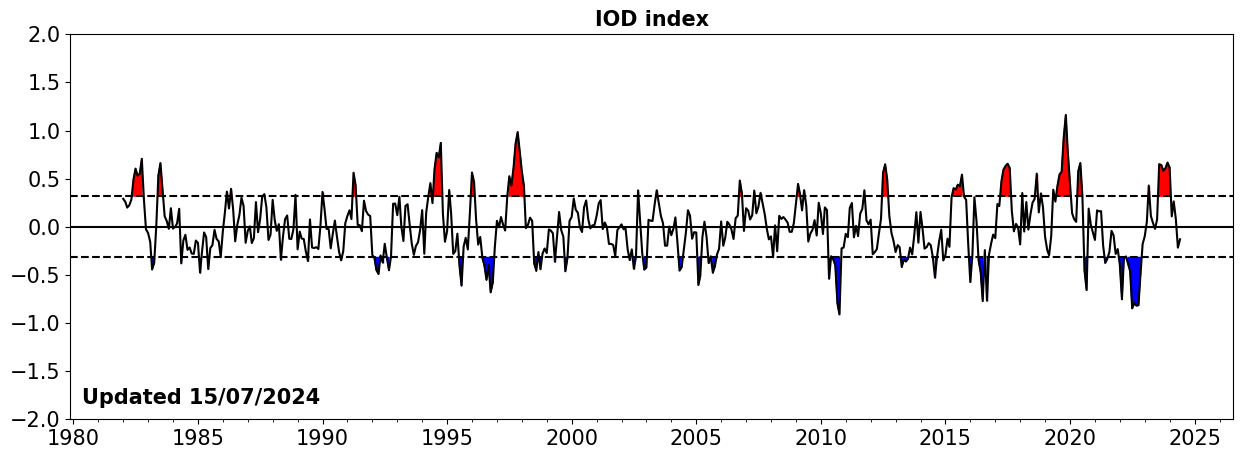

In [16]:
plot_IOD(iod_cobe)

### ERSST v5

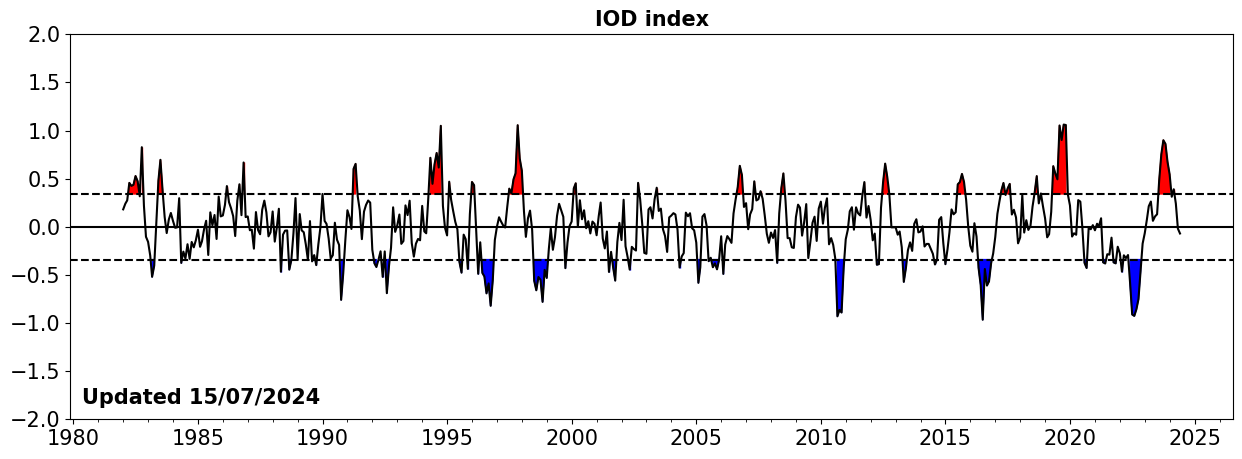

In [17]:
plot_IOD(iod_ersst)

# Identification of Atlantic Niños/Niños and Benguela Niños/Niñas <a id='test9'></a>

### Atlantic Niño events since 1982

In [18]:
_,_,table_atl3_w,table_atl3_c = create_table_event(ssta_atl3_norm_ersst)
table_atl3_w

,Start date,End date,Duration,Mean SSTa,Cumul SSTa,Max SSTa,Date max SSTa
0,1984-06,1984-10,4,1.63,6.52,2.20,1984-09-01
1,1987-06,1987-10,4,1.99,7.95,2.83,1987-07-01
2,1988-03,1988-09,6,2.21,13.27,3.12,1988-07-01
3,1989-06,1989-10,4,1.20,4.82,1.34,1989-08-01
4,1993-09,1994-01,4,1.44,5.76,2.10,1993-11-01
5,1995-05,1995-08,3,1.44,4.32,1.55,1995-06-01
6,1996-05,1996-08,3,1.76,5.29,2.51,1996-06-01
7,1997-12,1998-03,3,1.53,4.58,1.61,1998-01-01
8,1998-06,1998-09,3,1.28,3.85,1.57,1998-06-01
9,2016-10,2017-01,3,1.20,3.59,1.40,2016-11-01


### Atlantic Niña events since 1982

In [19]:
table_atl3_c

,Start date,End date,Duration,Mean SSTa,Cumul SSTa,Max SSTa,Date max SSTa
0,1982-06,1982-09,3,-1.51,-4.53,-1.79,1982-07-01
1,1991-11,1992-02,3,-1.56,-4.69,-1.84,1991-11-01
2,1992-04,1992-10,6,-1.71,-10.28,-2.42,1992-05-01
3,1996-11,1997-08,9,-1.62,-14.54,-2.63,1997-06-01
4,2000-06,2000-12,6,-1.25,-7.51,-1.33,2000-07-01
5,2001-11,2002-02,3,-1.85,-5.54,-2.37,2001-12-01
6,2004-04,2004-07,3,-1.37,-4.12,-1.54,2004-04-01
7,2005-05,2005-08,3,-2.60,-7.79,-3.25,2005-06-01
8,2009-07,2009-12,5,-1.36,-6.79,-1.71,2009-08-01
9,2011-12,2012-09,9,-1.60,-14.37,-2.00,2012-02-01


### Benguela Niño events since 1982

In [20]:
_,_,table_aba_w,table_aba_c = create_table_event(ssta_aba_norm_ersst)
table_aba_w

,Start date,End date,Duration,Mean SSTa,Cumul SSTa,Max SSTa,Date max SSTa
0,1984-02,1984-10,8,2.33,18.66,3.06,1984-03-01
1,1991-05,1991-08,3,1.79,5.38,2.50,1991-05-01
2,1994-10,1995-01,3,1.40,4.21,1.55,1994-10-01
3,1995-02,1995-06,4,2.59,10.37,3.37,1995-04-01
4,1996-03,1996-07,4,1.62,6.46,2.30,1996-04-01
5,1997-10,1998-02,4,1.57,6.29,1.77,1997-12-01
6,2011-01,2011-05,4,1.75,7.01,1.90,2011-03-01
7,2019-11,2020-02,3,1.76,5.27,2.17,2019-11-01
8,2021-05,2021-09,4,1.75,7.02,2.18,2021-06-01
9,2023-12,2024-03,3,1.51,4.53,1.89,2023-12-01


### Benguela Niña events since 1982

In [21]:
table_aba_c

,Start date,End date,Duration,Mean SSTa,Cumul SSTa,Max SSTa,Date max SSTa
0,1983-03,1983-08,5,-1.35,-6.73,-1.79,1983-04-01
1,1992-06,1992-09,3,-1.56,-4.67,-1.63,1992-06-01
2,1996-11,1997-07,8,-1.94,-15.51,-3.02,1997-03-01
3,2001-12,2002-03,3,-1.39,-4.16,-1.84,2002-01-01
4,2004-03,2004-06,3,-2.24,-6.71,-3.09,2004-04-01
5,2005-04,2005-09,5,-1.66,-8.31,-2.61,2005-05-01
6,2010-02,2010-05,3,-1.48,-4.43,-1.84,2010-04-01
7,2011-06,2011-09,3,-1.13,-3.40,-1.21,2011-08-01
8,2011-11,2012-04,5,-1.74,-8.70,-2.38,2012-01-01


# Canonical/Non-canonical Atlantic Niños <a id='test6'></a>

Figure inspired by the Richter et al., (2013), in which they identify some warm events that can not be explained by previously identify equatorial wind stress forcing. 

--> A warm SST event is categorized as a canonical (non-canonical) event when it is preceded by a
positive (negative) surface wind anomaly. Hence, canonical events lie in the upper right (in red) and lower left (in blue), and non-canonical events lie in the upper left and lower right (in black) quadrants.  

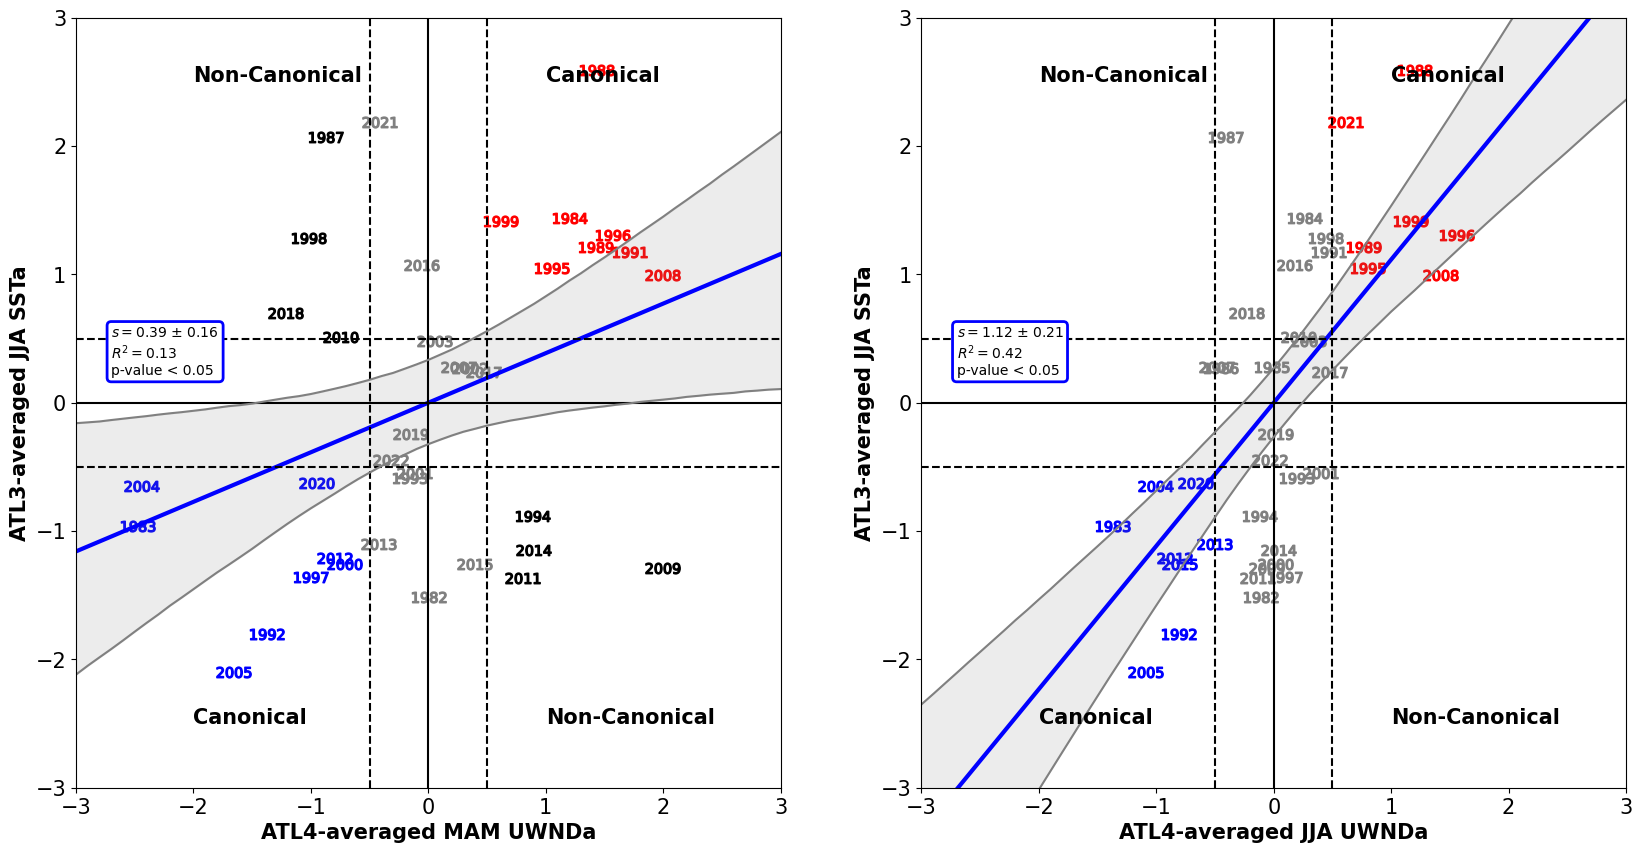

In [22]:
plot_canonical_atlantic_ninos(uwnda_atl4_norm,ssta_atl3_norm_ersst)

# [Forecast from CFSv2 next three month](https://www.cpc.ncep.noaa.gov/products/CFSv2/CFSv2_body.html) <a id='test8'></a>

# +1 month

In [23]:
Image(url='https://www.cpc.ncep.noaa.gov/products/CFSv2/imagesInd3/glbSSTMonInd2.gif')  

# +2 month

In [24]:
Image(url='https://www.cpc.ncep.noaa.gov/products/CFSv2/imagesInd3/glbSSTMonInd3.gif') 

# +3 Month

In [25]:
Image(url='https://www.cpc.ncep.noaa.gov/products/CFSv2/imagesInd3/glbSSTMonInd4.gif') 

# Last days SST anomalies 

In [26]:
Image(url='https://climatereanalyzer.org/wx/todays-weather/maps/gfs_world-wt_sstanom_d1.png')

# Last days SST 

In [27]:
Image(url='https://climatereanalyzer.org/wx/todays-weather/maps/gfs_world-wt_sst_d1.png') 

# [Animations from the CPC](https://www.cpc.ncep.noaa.gov/products/GODAS/background.shtml)

# [Subsurface temperature anomalies](https://www.cpc.ncep.noaa.gov/products/GODAS/)

In [28]:
Image(url='https://www.cpc.ncep.noaa.gov/products/GODAS/pent_gif/xz/movie.temp.0n.gif',width=800)

# [Z20 anomalies](https://www.cpc.ncep.noaa.gov/products/GODAS/)

In [29]:
Image(url='https://www.cpc.ncep.noaa.gov/products/GODAS/pent_gif/xy/movie.d20.gif',width=800)

# References <a id='test20'></a>

- Caniaux, G., H. Giordani, J.‐L. Redelsperger, F. Guichard, E. Key, and M. Wade (2011), Coupling between the Atlantic cold tongue and the West African monsoon in boreal spring and summer, J. Geophys. Res., 116, C04003,
doi:10.1029/2010JC006570.
- Chiang, J. C. H., & Vimont, D. J. (2004). Analogous Pacific and Atlantic Meridional Modes of Tropical Atmosphere–Ocean Variability, Journal of Climate, 17(21), 4143-4158.
- Enfield, D.B., A.M. Mestas-Nunez, and P.J. Trimble, 2001: The Atlantic Multidecadal Oscillation and its relationship to rainfall and river flows in the continental U.S., Geophys. Res. Lett., 28: 2077-2080.
- Fontaine, B., and S. Louvet (2006), Sudan-Sahel rainfall onset: Definition of an objective index, types of years, and experimental hindcasts, J. Geophys. Res., 111, D20103, doi:10.1029/2005JD007019.
- Richter, I., Behera, S., Masumoto, Y. et al. Multiple causes of interannual sea surface temperature variability in the equatorial Atlantic Ocean. Nature Geosci 6, 43–47 (2013). https://doi.org/10.1038/ngeo1660